<a href="https://colab.research.google.com/github/ucancallmetigger-ui/Fraud_Shield_AI/blob/main/Fraud_Shield_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
n_samples = 100000

data = {
    'Time': np.random.uniform(0, 172800, n_samples),
    'Amount': np.random.lognormal(4.5, 1.2, n_samples),
}
df = pd.DataFrame(data)

for i in range(1, 29):
    df[f'V{i}'] = np.random.normal(0, 1, n_samples)

df['Hour'] = df['Time'] // 3600
df['Amount_to_Mean'] = df['Amount'] / df['Amount'].mean()
df['Amount_Log'] = np.log1p(df['Amount'])
df['Is_Night'] = ((df['Hour'] >= 0) & (df['Hour'] < 6)).astype(int)
df['V1_V2_Ratio'] = df['V1'] / (df['V2'] + 1e-6)

df['Class'] = 0
fraud_ratio = 0.005
n_fraud = int(n_samples * fraud_ratio)
fraud_idx = np.random.choice(df.index, n_fraud, replace=False)
df.loc[fraud_idx, 'Class'] = 1

df.loc[fraud_idx, 'V1'] += np.random.normal(-5, 2.8, n_fraud)
df.loc[fraud_idx, 'V3'] += np.random.normal(-7, 3.5, n_fraud)
df.loc[fraud_idx, 'V4'] += np.random.normal(4.5, 2.2, n_fraud)
df.loc[fraud_idx, 'V9'] += np.random.normal(-3.5, 2, n_fraud)
df.loc[fraud_idx, 'V11'] += np.random.normal(4, 2.5, n_fraud)
df.loc[fraud_idx, 'V14'] += np.random.normal(-8, 4, n_fraud)
df.loc[fraud_idx, 'Amount'] = np.random.lognormal(6.5, 1.8, n_fraud)
df.loc[fraud_idx, 'Amount_Log'] = np.log1p(df.loc[fraud_idx, 'Amount'])
df.loc[fraud_idx, 'Amount_to_Mean'] = df.loc[fraud_idx, 'Amount'] / df['Amount'].mean()
df.loc[fraud_idx, 'Is_Night'] = np.random.choice([0, 1], n_fraud, p=[0.3, 0.7])

In [3]:
features = [col for col in df.columns if col != 'Class']
X = df[features]
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

In [4]:
iso_forest = IsolationForest(contamination=0.005, random_state=42, n_jobs=-1)
iso_forest.fit(X_train_scaled)
y_pred_iso = iso_forest.predict(X_test_scaled)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

print("Isolation Forest")
print(classification_report(y_test, y_pred_iso, digits=4))

Isolation Forest
              precision    recall  f1-score   support

           0     0.9986    0.9985    0.9986     19900
           1     0.7157    0.7300    0.7228       100

    accuracy                         0.9972     20000
   macro avg     0.8572    0.8643    0.8607     20000
weighted avg     0.9972    0.9972    0.9972     20000



In [5]:
xgb = XGBClassifier(
    n_estimators=1000,
    max_depth=8,
    learning_rate=0.03,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in cv.split(X_train_res, y_train_res):
    X_tr, X_val = X_train_res[train_idx], X_train_res[val_idx]
    y_tr, y_val = y_train_res[train_idx], y_train_res[val_idx]
    xgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

y_pred_xgb = xgb.fit(X_train_res, y_train_res).predict(X_test_scaled)
y_prob_xgb = xgb.predict_proba(X_test_scaled)[:,1]

print("XGBoost")
print(classification_report(y_test, y_pred_xgb, digits=4))

precision, recall, _ = precision_recall_curve(y_test, y_prob_xgb)
print(f"PR-AUC: {auc(recall, precision):.4f}")

XGBoost
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     19900
           1     1.0000    1.0000    1.0000       100

    accuracy                         1.0000     20000
   macro avg     1.0000    1.0000    1.0000     20000
weighted avg     1.0000    1.0000    1.0000     20000

PR-AUC: 1.0000


In [6]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = X_train_scaled.shape[1]
autoencoder = Autoencoder(input_dim)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0005)
criterion = nn.MSELoss()

normal_mask = (y_train.values == 0)
train_tensor = torch.tensor(X_train_scaled[normal_mask], dtype=torch.float32)
train_loader = DataLoader(TensorDataset(train_tensor, train_tensor), batch_size=256, shuffle=True)

for epoch in range(50):
    autoencoder.train()
    for data, _ in train_loader:
        optimizer.zero_grad()
        output = autoencoder(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()

autoencoder.eval()
with torch.no_grad():
    recon = autoencoder(torch.tensor(X_test_scaled, dtype=torch.float32))
    mse = torch.mean((recon - torch.tensor(X_test_scaled, dtype=torch.float32))**2, dim=1).numpy()

normal_test_mask = (y_test.values == 0)
threshold = np.percentile(mse[normal_test_mask], 99.8)
y_pred_ae = (mse > threshold).astype(int)

print("Autoencoder Anomaly Detection")
print(classification_report(y_test, y_pred_ae, digits=4))

Autoencoder Anomaly Detection
              precision    recall  f1-score   support

           0     1.0000    0.9980    0.9990     19900
           1     0.7143    1.0000    0.8333       100

    accuracy                         0.9980     20000
   macro avg     0.8571    0.9990    0.9162     20000
weighted avg     0.9986    0.9980    0.9982     20000



In [7]:
rf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train_res, y_train_res)
y_prob_rf = rf.predict_proba(X_test_scaled)[:,1]

logreg = LogisticRegression(random_state=42, max_iter=2000)
logreg.fit(X_train_res, y_train_res)
y_prob_lr = logreg.predict_proba(X_test_scaled)[:,1]

ensemble_prob = (y_prob_xgb + y_prob_rf + y_prob_lr + (1 - mse / mse.max())) / 4
y_pred_ensemble = (ensemble_prob > 0.5).astype(int)

print("Ensemble (XGBoost + RandomForest + Logistic + Autoencoder)")
print(classification_report(y_test, y_pred_ensemble, digits=4))

precision, recall, _ = precision_recall_curve(y_test, ensemble_prob)
print(f"Ensemble PR-AUC: {auc(recall, precision):.4f}")
print(confusion_matrix(y_test, y_pred_ensemble))

Ensemble (XGBoost + RandomForest + Logistic + Autoencoder)
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     19900
           1     1.0000    1.0000    1.0000       100

    accuracy                         1.0000     20000
   macro avg     1.0000    1.0000    1.0000     20000
weighted avg     1.0000    1.0000    1.0000     20000

Ensemble PR-AUC: 1.0000
[[19900     0]
 [    0   100]]


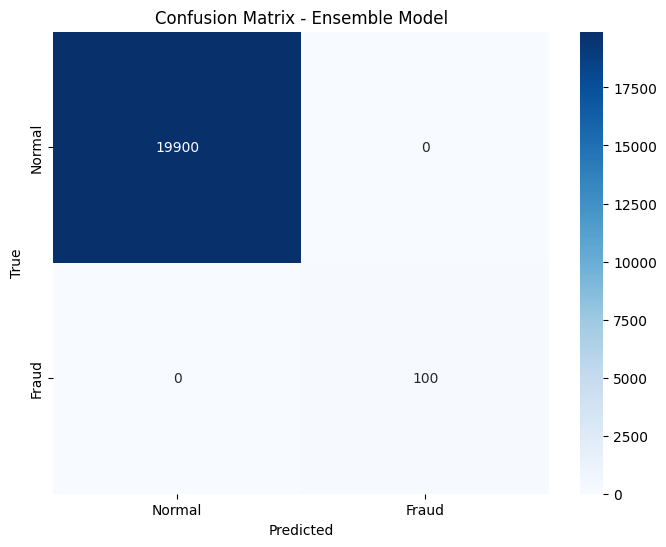

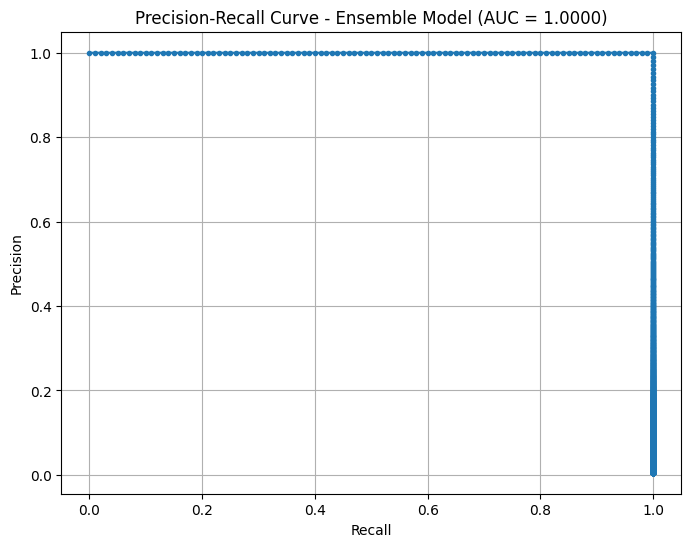

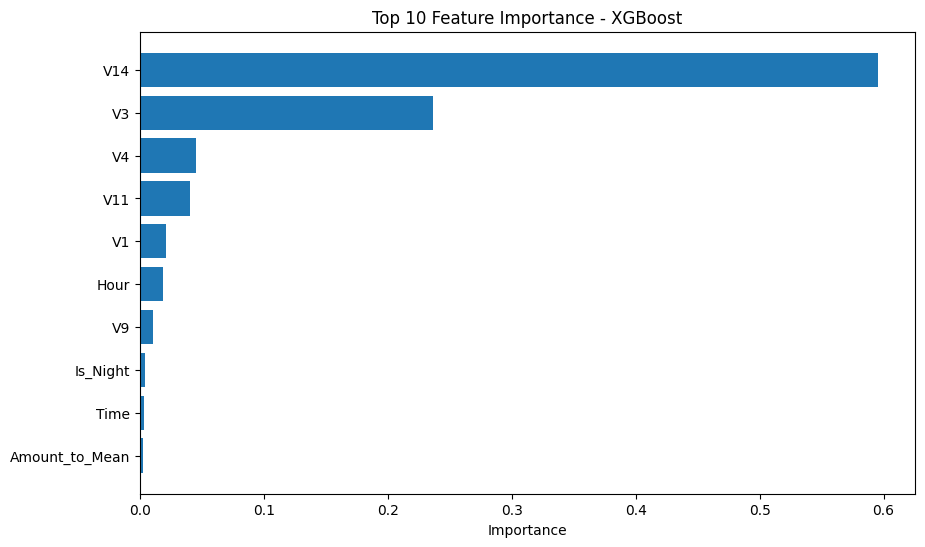

In [8]:
cm = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Ensemble Model')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Ensemble Model (AUC = {:.4f})'.format(auc(recall, precision)))
plt.grid(True)
plt.show()

feature_importance = xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)[-10:]
plt.figure(figsize=(10,6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance - XGBoost')
plt.show()